# Логические алгоритмы классификации

## Решающие деревья для регрессии

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style='whitegrid')

Сгенерируем выборку из двумерного нормального распределения. Предсказываемой меткой регрессии назначим расстояние до точки от начала координат:

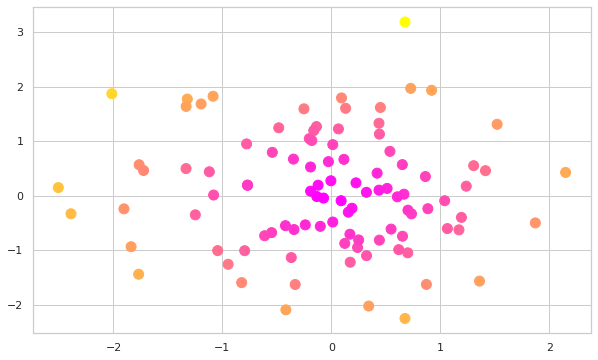

In [2]:
np.random.seed(23)
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5
plt.figure(figsize=(10, 6))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

### Визуализация

Пару вспомогательных функций для того, чтобы рисовать красивые цветные графики. С помощью них можно рисовать на плоскости с помощью цветов то, как модель предсказывает ответы (очень пригодится нам дальше):

In [3]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                       np.arange(y_min, y_max, 0.01))

In [4]:
def plot_model(X, y, clf, proba=False):
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.pcolormesh(xx, yy, predicted, cmap='spring')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=150, cmap='spring', alpha=0.7, marker='H', edgecolor='black')
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    return clf

Наслаждаемся результатами работы!

DecisionTreeRegressor()

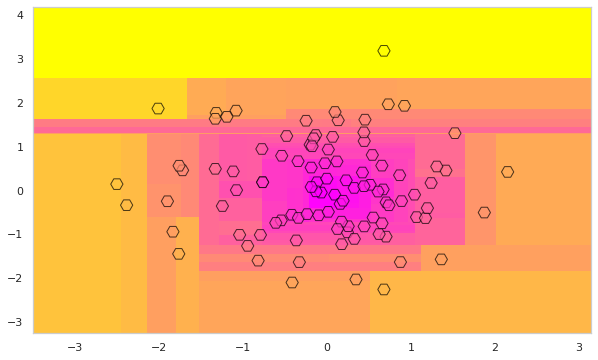

In [5]:
from sklearn.tree import DecisionTreeRegressor

plt.figure(figsize=(10, 6))
clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)
plot_model(data_x, data_y, clf)

Т.к. одно из главных преимуществ решающих деревьев - это интерпретируемость правил, хотелось бы их увидеть. Сказано - сделано!

In [6]:
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import IPython

def draw_tree(clf, feature_names):
    dot_data = StringIO()
    export_graphviz(clf, feature_names=feature_names, 
                    out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    img = Image(value=graph.create_png())
    IPython.display.display(img)

In [7]:
clf = DecisionTreeRegressor(max_depth=3)
clf.fit(data_x, data_y)

draw_tree(clf, ['x1', 'x2'])

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05t\x00\x00\x01\xf1\x08\x02\x00\x00\x00B\xa5\xa3\xe…

### Перебор параметров

У дерева есть некоторое количество различных гиперпараметров, которые достаточно сильно влияют на его построение. Например:
* max_depth - максимальная глубина дерева
* min_samples_leaf - минимальное количество объектов в листе дерева

Давайте попробуем их перебрать и посмотреть, как меняется наше дерево:

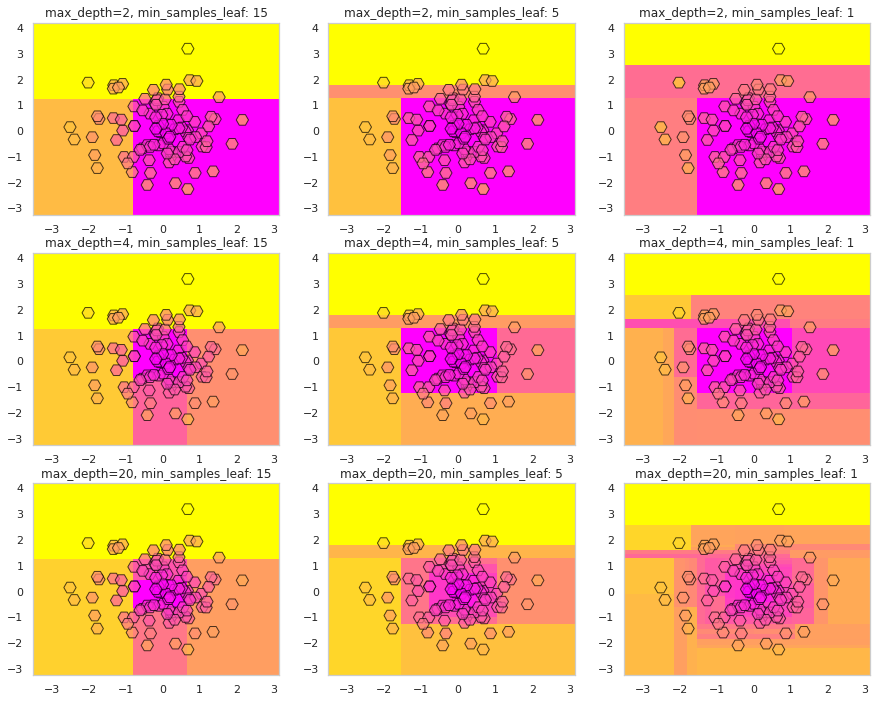

In [8]:
plt.figure(figsize=(15.0, 12.0))
for i, max_depth in enumerate([2, 4, 20]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        plt.subplot2grid((3, 3), (i, j))
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        plot_model(data_x, data_y, clf)
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

Так какой теперь ответ на вопросы о том, как влияет глубина и количество элементов в листе на переобучение? :)

### Неустойчивость

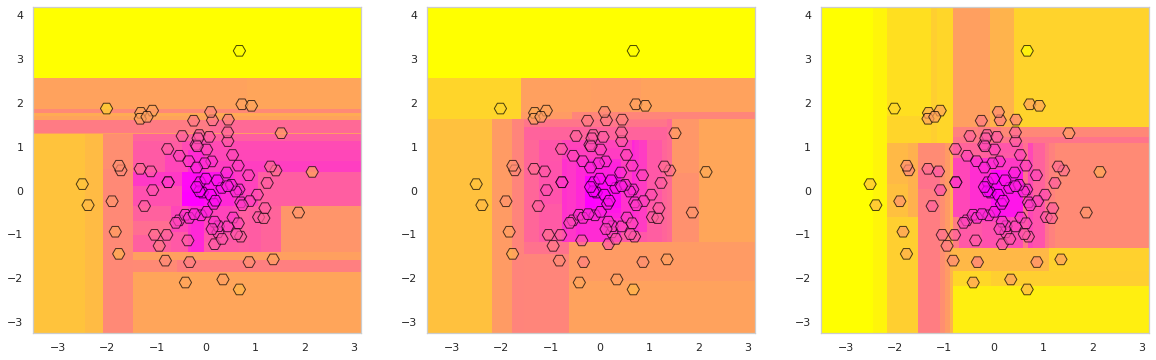

In [9]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=23)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plot_model(data_x, data_y, clf)

## Решающие деревья для классификации

Для начала сгенерируем два набора объектов из нормальных распределений с разными центрами:

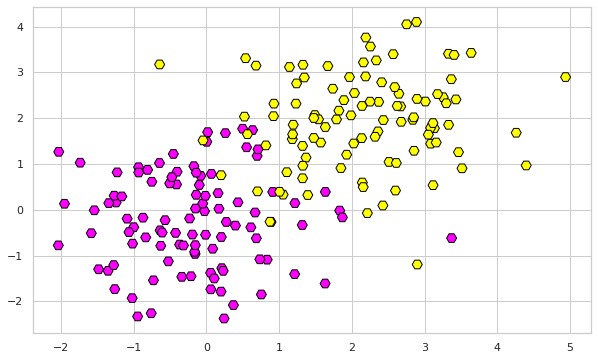

In [10]:
# first class
data_x = np.random.normal(size=(100, 2))
data_y = np.zeros(100)

# second class
data_x = np.r_[data_x, np.random.normal(size=(100, 2), loc=2)]
data_y = np.r_[data_y, np.ones(100)]

plt.figure(figsize=(10.0, 6.0))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', marker='H', edgecolors='black')

### Визуализация

Тут всё аналогично регрессору. Разве что графики получаются двухцветными:

DecisionTreeClassifier(max_depth=3)

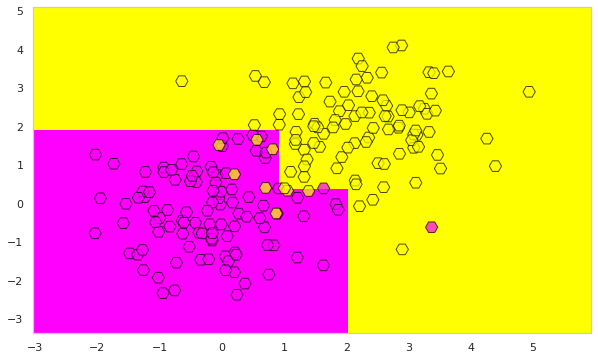

In [11]:
from sklearn.tree import DecisionTreeClassifier

plt.figure(figsize=(10, 6))
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(data_x, data_y)
plot_model(data_x, data_y, clf)

Но не беда! В некотором роде классификация - это тоже регрессия, но на вероятностях. Давайте визуализировать их, чтобы получить красивые градиентные переходы:

DecisionTreeClassifier(min_samples_leaf=5)

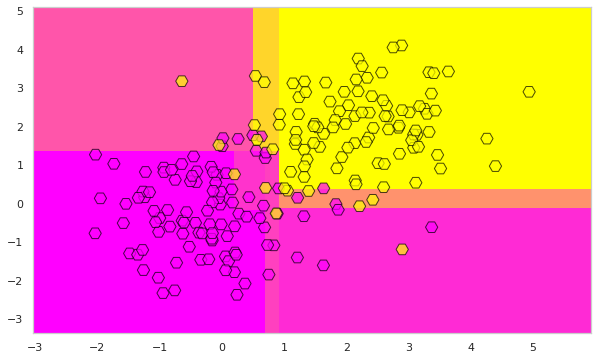

In [12]:
plt.figure(figsize=(10, 6))
clf = DecisionTreeClassifier(min_samples_leaf=5)
clf.fit(data_x, data_y)
plot_model(data_x, data_y, clf, proba=True)

### Перебор параметров

Посмотрим как различные параметры влияют на качество модели:

In [13]:
param_grid = [{'max_depth': [2, 3, 5, 10], 'min_samples_leaf': [1, 3, 7, 20]}]

from sklearn.model_selection import GridSearchCV
searcher = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
searcher.fit(data_x, data_y)

print (searcher.best_estimator_)

df = pd.DataFrame(searcher.cv_results_)

DecisionTreeClassifier(max_depth=3)


In [14]:
df = df[['params', 'mean_test_score', 'std_test_score']]
df

,params,mean_test_score,std_test_score
0,"{'max_depth': 2, 'min_samples_leaf': 1}",0.910,0.040620
1,"{'max_depth': 2, 'min_samples_leaf': 3}",0.900,0.041833
2,"{'max_depth': 2, 'min_samples_leaf': 7}",0.900,0.044721
3,"{'max_depth': 2, 'min_samples_leaf': 20}",0.895,0.043012
4,"{'max_depth': 3, 'min_samples_leaf': 1}",0.915,0.040620
5,"{'max_depth': 3, 'min_samples_leaf': 3}",0.905,0.043012
6,"{'max_depth': 3, 'min_samples_leaf': 7}",0.900,0.044721
7,"{'max_depth': 3, 'min_samples_leaf': 20}",0.895,0.043012
8,"{'max_depth': 5, 'min_samples_leaf': 1}",0.900,0.059161
9,"{'max_depth': 5, 'min_samples_leaf': 3}",0.905,0.043012


## Сравнение с линейной регрессией

Давайте теперь сравним (в смысле вы сравните) линейный классификатор и решающее дерево.

**Задание 1 (0.5 баллов).** Сгенерируйте выборку в виде решётки, где объекты одного класса лежат в целочисленных точках ниже прямой $y=x$, а другого выше этой прямой. Должно получиться что-то такое:

<img src="https://www.dropbox.com/s/24j8etej64hus5g/Screenshot%20from%202020-03-02%2018-32-25.png?raw=1">

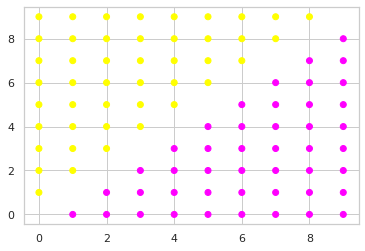

In [15]:
### YOUR CODE HERE

data_x = []
data_y = []
for x in range(10):
  for y in range(10):
    if x != y:
      data_x.append([x, y])
      data_y.append(1 if x < y else 0)

data_x = np.array(data_x)
data_y = np.array(data_y)

plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, cmap='spring')

**Задание 2 (0.5 балла)**. Сравните, как будет выглядеть раскрашенная плоскость для классификатора, являющегося решающим деревом и для классификатора, являющимся логистической регрессией.

DecisionTreeClassifier(max_depth=3)

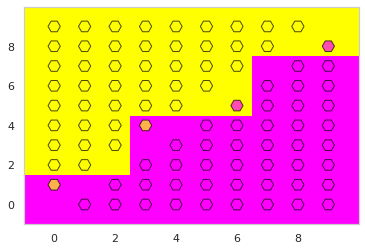

In [16]:
### YOUR CODE HERE

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(data_x, data_y)
plot_model(data_x, data_y, clf)

DecisionTreeRegressor(max_depth=3)

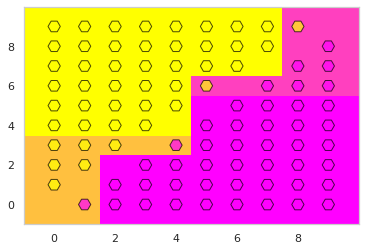

In [17]:
clf = DecisionTreeRegressor(max_depth=3)
clf.fit(data_x, data_y)

plot_model(data_x, data_y, clf)

**Задание 3 (1 балл).** А теперь поинтереснее: сгенерируйте аналогичную выборку, но только в которой ближайшие к $y=x$ диагональные ряды являются объектами другого класса. И сравните алгоритмы на этой выборке.

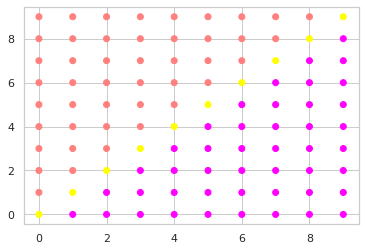

In [18]:
### YOUR CODE HERE

data_x = []
data_y = []
for x in range(10):
  for y in range(10):
    if x != y:
      data_x.append([x, y])
      data_y.append(1 if x < y else 0)
    else:
      data_x.append([x, y])
      data_y.append(2)

data_x = np.array(data_x)
data_y = np.array(data_y)

plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, cmap='spring')

DecisionTreeClassifier(max_depth=3)

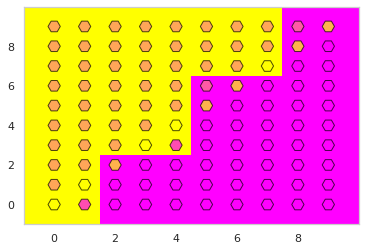

In [19]:
### YOUR CODE HERE

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(data_x, data_y)
plot_model(data_x, data_y, clf)

DecisionTreeRegressor(max_depth=3)

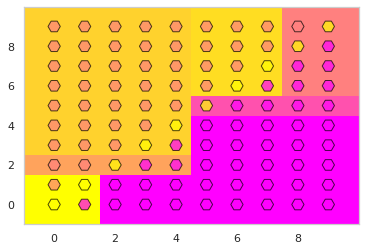

In [20]:
clf = DecisionTreeRegressor(max_depth=3)
clf.fit(data_x, data_y)

plot_model(data_x, data_y, clf)